In [1]:
import h5py
import pandas as pd
import numpy as np
import os
import glob
import pylab as pl
import imageio

In [2]:
import analysis_utils as au

In [3]:
%matplotlib notebook

In [4]:
rootdir = '/home/julianarhee/Videos/basler-tests'
# experiment = 'JB999_220703_182337'
#experiment = 'JB999_220705_141018' #135834'
experiment = 'JB999'
datestr = '220705_205857' #13583'
expid = '%s_%s' % (experiment, datestr)
ext='csv'
srcdir = os.path.join(rootdir, expid)

# fn1 = '/home/julianarhee/Videos/basler-pq/%s/left_top_metadata.%s' % (experiment, ext)
# fn2 = '/home/julianarhee/Videos/basler-pq/%s/right_top_metadata.%s' % (experiment, ext)
cam_list = ['lefttop', 'righttop']
finfo = dict((c, dict()) for c in cam_list)
for ci, cam_name in enumerate(cam_list):
    fn = sorted(glob.glob(os.path.join(srcdir, '{}_*_metadata.{}'.format(cam_name, ext))), 
                key=au.natural_keys)
    finfo[cam_name] = fn
for cam_name, fpaths in finfo.items():
    print("{}: {} files".format(cam_name, len(fpaths)))

lefttop: 13 files
righttop: 13 files


In [5]:
cam1, cam2 = cam_list
file_num = 0

fn1 = finfo[cam1][file_num]
print(fn1)
fn2 = fn1.replace(cam1, cam2)
print(fn2)

/home/julianarhee/Videos/basler-tests/JB999_220705_205857/lefttop_20220705205857_00000_metadata.csv
/home/julianarhee/Videos/basler-tests/JB999_220705_205857/righttop_20220705205857_00000_metadata.csv


In [6]:
if ext == 'csv':
    df1 = pd.read_csv(fn1, sep=',')
    df2 = pd.read_csv(fn2, sep=',')
    print(df1.shape, df2.shape)

(17999, 6) (17999, 6)


In [7]:
df1

,serial,framecount,frameid,timestamp,sestime,cputime
0,22297042,2,2,6.986366,7.066018,1.657069e+09
1,22297042,3,3,7.186590,7.264100,1.657069e+09
2,22297042,4,4,7.386813,7.465099,1.657069e+09
3,22297042,5,5,7.587037,7.663624,1.657069e+09
4,22297042,6,6,7.787261,7.863995,1.657069e+09
...,...,...,...,...,...,...
17994,22297042,17996,17996,3609.797182,3609.857569,1.657073e+09
17995,22297042,17997,17997,3609.997404,3610.057724,1.657073e+09
17996,22297042,17998,17998,3610.197627,3610.256427,1.657073e+09
17997,22297042,17999,17999,3610.397849,3610.456509,1.657073e+09


## hdf5

In [8]:
# metadata = (framecount, timestamp, arrival_time, sestime, cputime)
# (framecount, timestamp, sestime, cputime)

In [84]:
varnames = 'sestime' #'serial' #['sestime', 'serial']
#df1 = pd.read_hdf(fn2) #, columns=varnames)
df1 = pd.DataFrame(np.array(h5py.File(fn1)[varnames]))

df1

,0
0,8.503429


In [55]:
df2 = pd.DataFrame(np.array(h5py.File(fn2)[varnames]))
df2

,0
0,7.040115
1,7.139839
2,7.237447
3,7.334959
4,7.435203
...,...
17333,1742.265640
17334,1742.367398
17335,1742.465761
17336,1742.565989


In [56]:
df2[0].diff().dropna().values.min(), df2[0].diff().dropna().values.max()

(0.09691368700077874, 0.10317300600218005)

In [57]:
1/20.

0.05

In [58]:
df1[0].diff().dropna().values.min(), df1[0].diff().dropna().values.max()

(0.09628111900019576, 0.10395854199668975)

In [59]:
diffs = df2.values - df1.values

<IPython.core.display.Javascript object>


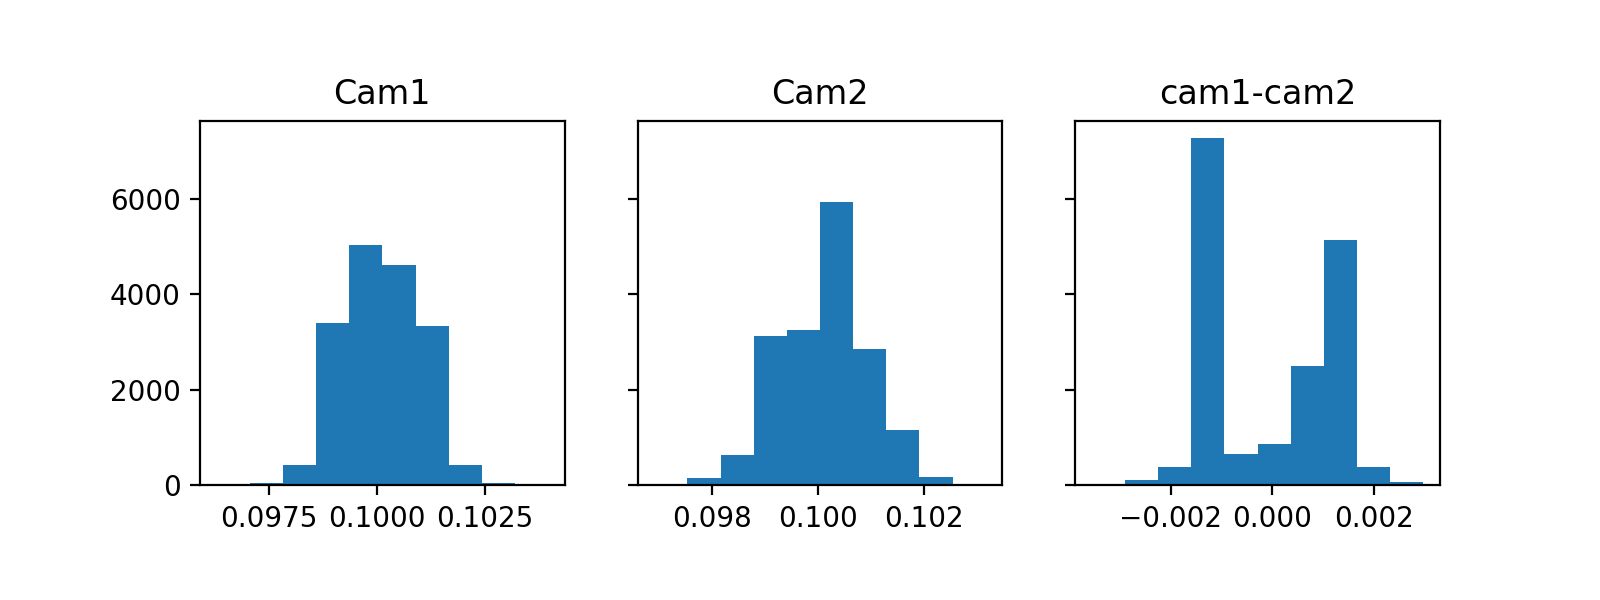

In [60]:
fig, axes =pl.subplots(1,3, figsize=(8,3), sharex=False, sharey=True)
ax=axes[0]; ax.set_title('Cam1')
ax.hist(df1[0].diff().dropna().values)
ax=axes[1]; ax.set_title('Cam2')
ax.hist(df2[0].diff().dropna().values)
ax=axes[2]; ax.set_title('cam1-cam2')
ax.hist(diffs)
for ax in axes:
    ax.set_box_aspect(1)


# Video

In [20]:
import cv2
import time
import sys
from IPython import display

In [9]:
vext='mp4'
vpath1 = '%s.%s' % (fn1.split('_metadata')[0], vext)
#vpath2 = '%s.%s' % (fn2.split('_metadata')[0], vext)

print(vpath1)
#print(vpath2)

/home/julianarhee/Videos/basler-tests/JB999_220705_205857/lefttop_20220705205857_00000.mp4


In [10]:
vid = imageio.get_reader(vpath1,  'ffmpeg')

<IPython.core.display.Javascript object>


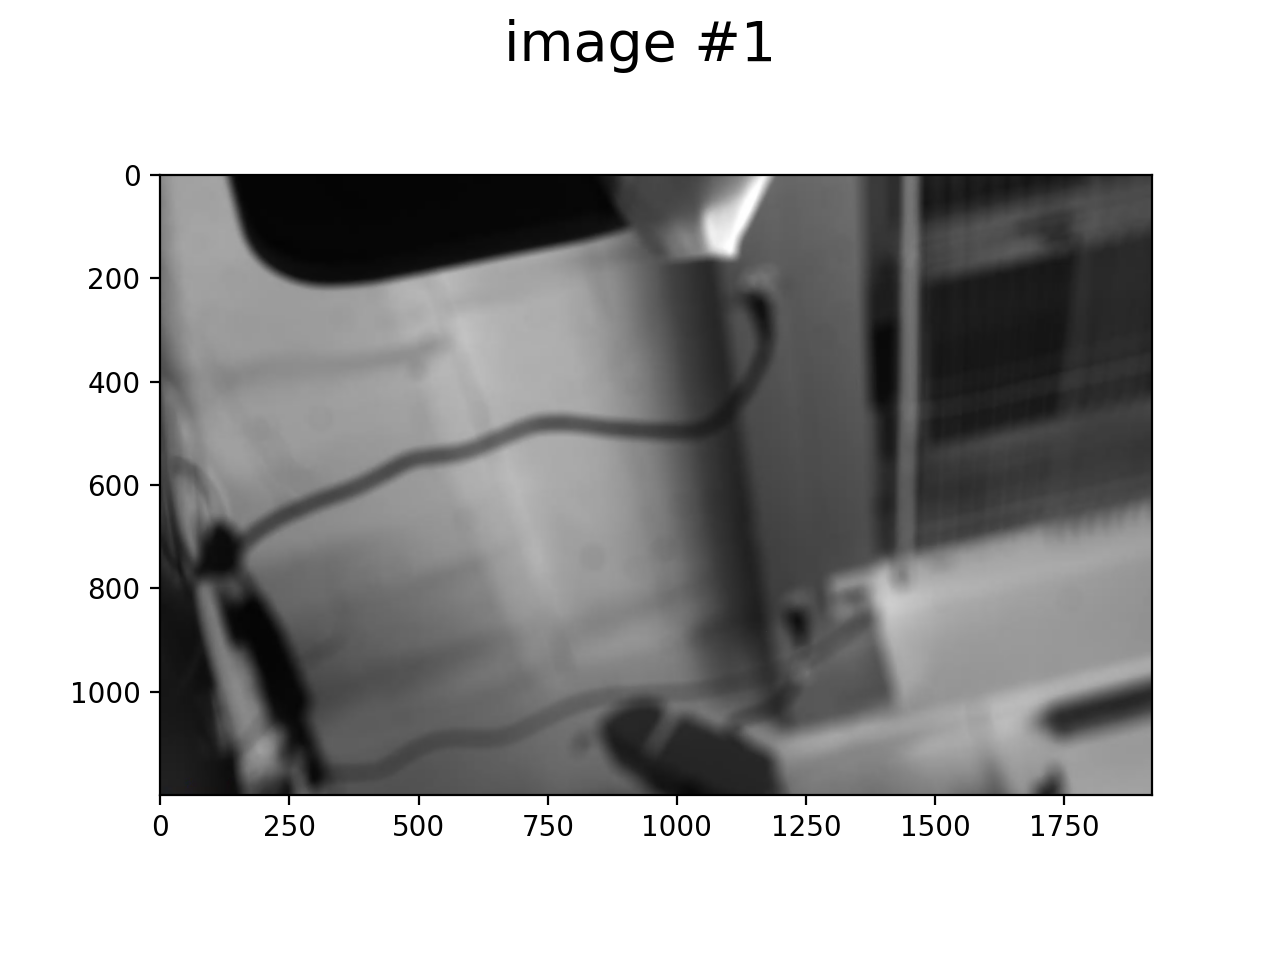

<IPython.core.display.Javascript object>


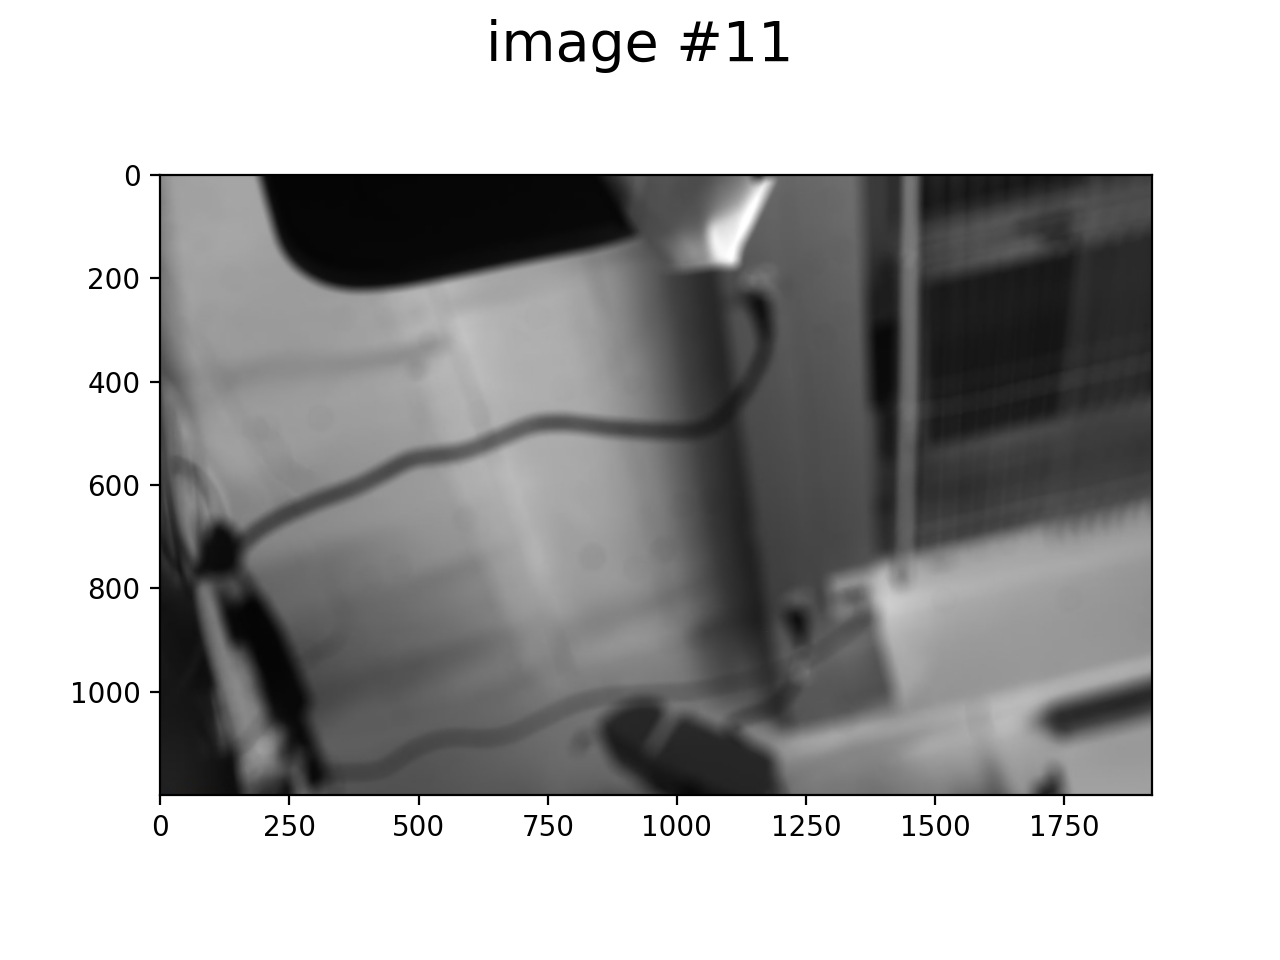

In [15]:
nums = [1, 11]
ims = dict((c, None) for c in nums)
for num in nums:
    image = vid.get_data(num)
    ims[num] = image
    fig = pl.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pl.imshow(image)
pl.show()

In [21]:
ims[1].size, ims[11].size

(6912000, 6912000)

In [23]:
sys.getsizeof(ims[1]), sys.getsizeof(ims[11])

(168, 168)

In [11]:
def load_frames(fn):
    frames = []
    video = cv2.VideoCapture(fn)
    while True:
        read, frame= video.read()
        if not read:
            break
        frames.append(frame[:,:,0])
    frames = np.array(frames)
    return frames


In [12]:

def plot_frames(ax, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            #y = np.random.random(size=(100,1))
            ax.imshow(color)
            #ax.plot(x, y, color)
    fig.canvas.draw()

In [ ]:
v1 = load_frames(vpath1)
#v2 = load_frames(vpath2)
print("%s: %i frames" % (vpath1, len(v1)))
#print("%s: %i frames" % (vpath2, len(v2)))

In [ ]:
print(v1.size, v1.shape)

#print(v2.size, v2.shape)

In [64]:
v1.dtype, v2.dtype

(dtype('uint8'), dtype('uint8'))

<IPython.core.display.Javascript object>


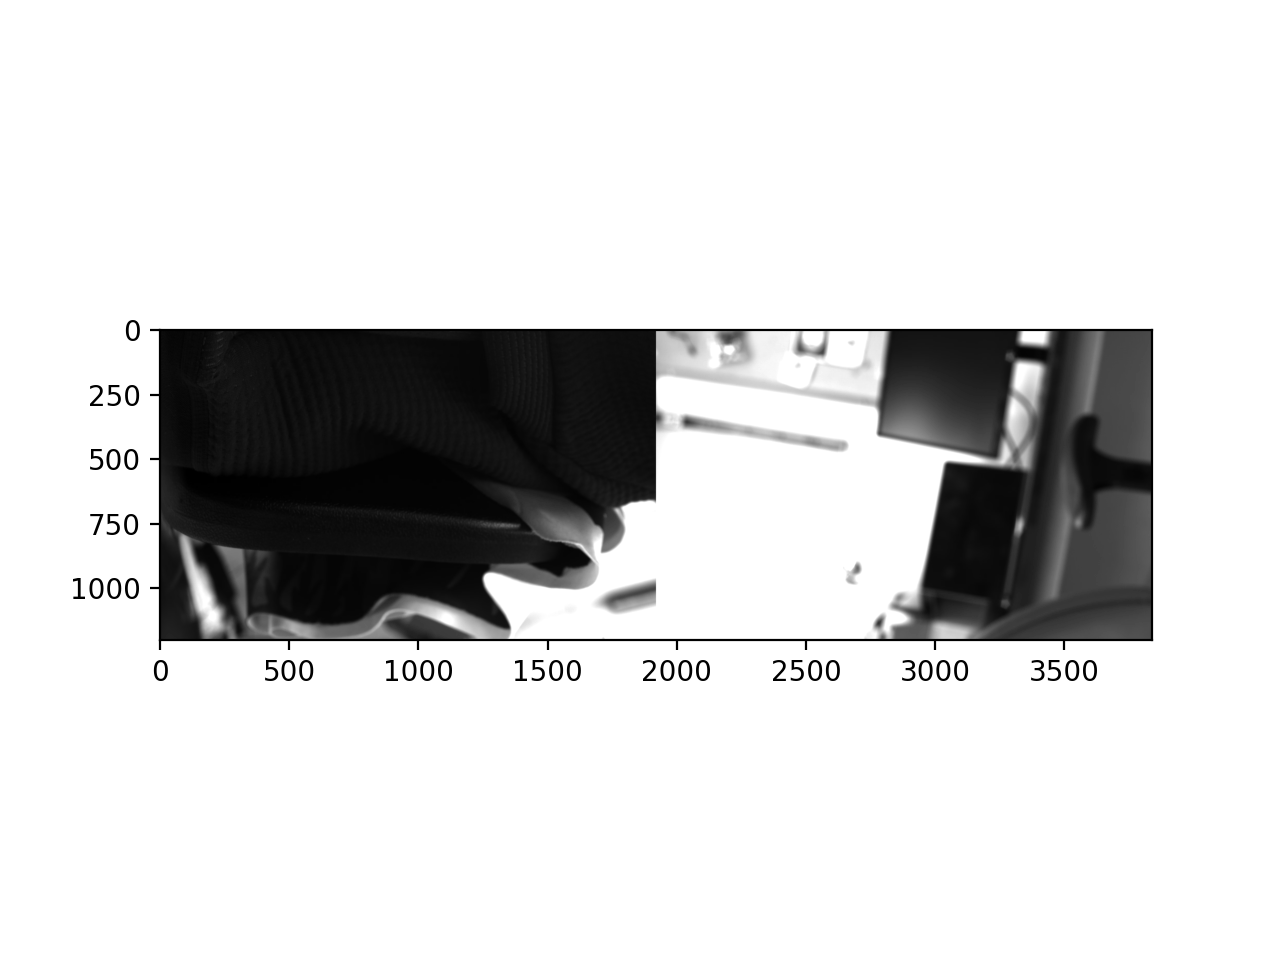

In [65]:
ix = 0
img = np.hstack((v1[ix,:,:], v2[ix,:,:]))
pl.figure()
pl.imshow(img, cmap='gray')

In [ ]:
fig, axes = pl.subplots(1,2)
#ix = -1
for ix in range(100):
    axes[0].imshow(v1[ix])
    axes[1].imshow(v2[ix])
    axes[0].set_title('frame %i' % ix)
#     pl.show()
#     time.sleep(1)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)
    

In [ ]:
fig,axes = pl.subplots(1,2)
for f in range(5):
    plot_frames(ax, ['b', 'r'])
    time.sleep(1)

In [26]:
v1.shape

(250, 1200, 1920, 3)